# Lab2 on Digital Image Processing on the topic "Detection of objects on satellite images using characteristic Haar features"
# Лабораторная работа №2 по Цифровой Обработке Изображений на тему "Детектирование объектов на спутниковых изображениях с использованием характерных признаков Хаара"
### Tasks:
1. Prepare a dataset of images (satellite photo) in accordance with the variant.
2. Create a project in Python3.x and import the scikit-image library (you cannot use opencv).
3. From labs 1.1, 1.2 take the modules for loading a color digital image and processing pixels.
4. Program the formula for converting a color digital image into a grayscale digital space.
5. Program the algorithm for determining the Haar characteristic features (extended set, the description of the features is given below, you cannot use opencv again!).
6. For the object in accordance with the variant (V1: passenger car, V2: truck, V3: roof of the house, V4: ship) find the values of the Haar characteristic signs (train the signs on the object).
7. Conduct an experiment on object recognition with visualization of the results (including visualization of the use of characteristic features in the image).
8. Comment on each line of code.
9. Send the program to the teacher.
10. Build a graph of errors of the first and second kind based on the recognition results.
11. Prepare and send a report (title page, assignment, theoretical part, diagram of the program structure, print screens of the interface and the main steps of the program, conclusion and conclusions, listing of the program with comments, list of used literature).

### Задачи:
1. Подготовить выборку изображений (фото со спутника) в соответствии с вариантом.
2. На языке Python3.x создать проект и подключить библиотеку scikit-image (opencv использовать нельзя).
3. Из лабораторной работы 1.1, 1.2 взять модули загрузки цветного цифрового изображения и обработки пикселей.
4. Запрограммировать формулу перевода цветового цифорового изображения в полутоновое цифровое пространство.
5. Запрограммировать алгоритм определения характерных признаков Хаара (расширенный набор, описание признаков дано ниже, ещё раз opencv использовать нельзя!).
6. Для объекта в соответствии с вариантом (В1: легковая машина, В2: грузовая машина, В3: крыша дома, В4: корабль) найти значения характерных признаков Хаара (обучить признаки на объекте).
7. Провести эксперимент по распознаванию объектов с визуализацией результатов (в том числе визуализацией применения характерных признаков на изображении).
8. Дать комментарий каждой строчке кода.
9. Прислать программу преподавателю.
10. Построить график ошибок первого и второго рода по результатам распознавания.
11. Подготовить и прислать отчёт (титульный лист, задание, теоретическая часть, диаграмма структуры программы, принтскрины интерфейса и основных шагов работы программы, заключение и выводы, листинг программы с комментариями, список использованной литературы).

In [1]:
import os
import numpy as np
from skimage import io
from skimage.transform import integral_image
from skimage.transform import resize
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline


DETECTION_WINDOW_WIDTH = 20
DETECTION_WINDOW_HEIGHT = 20

TRUCKS_PATH = os.path.join(os.getcwd(), 'dataset', 'train', 'trucks')
NONTRUCKS_PATH = os.path.join(os.getcwd(), 'dataset', 'train', 'nontrucks')
TEST_PATH = os.path.join(os.getcwd(), 'dataset', 'test')

# Dataset
# Набор данных
The dataset is satellite images. It consists of two parts: train and test. The images in the train part have a resolution of 150x150 pixels. The training part, in turn, is divided into images belonging to two classes: the first class - images with trucks, the second class - without them.

Набор данных представляет собой спутниковые изображения. Он состоит из двух частей: обучающей и тестовой. Изображения в обучающей части имеют разрешение 150x150 пикселей. Обучающая часть в свою очередь разделена на изображения, относящиеся к двум классам: первый класс - изображения с грузовыми машинами, второй класс - без них.

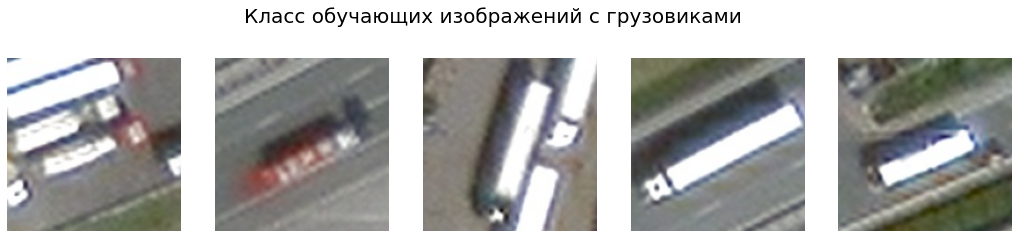

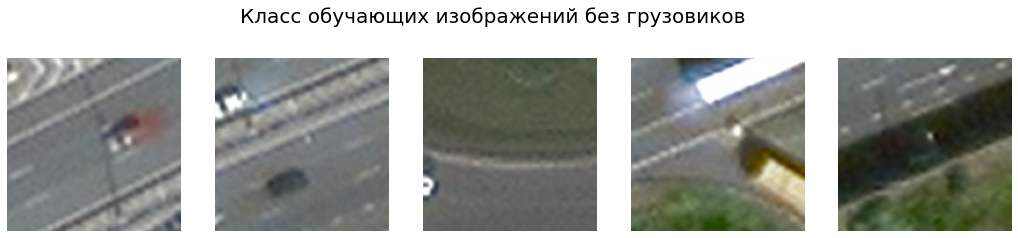

In [2]:
def show_images(path, shape, figsize, *, suptitle=None):
    n_rows, n_columns = shape
    
    file_names = os.listdir(path)
    
    rng = np.random.default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)
    
    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)


show_images(TRUCKS_PATH, (1, 5), (18, 4), suptitle='Класс обучающих изображений с грузовиками')
show_images(NONTRUCKS_PATH, (1, 5), (18, 4), suptitle='Класс обучающих изображений без грузовиков')

Тестовая обучающая часть состоит из пяти изображений, произвольного масштаба.

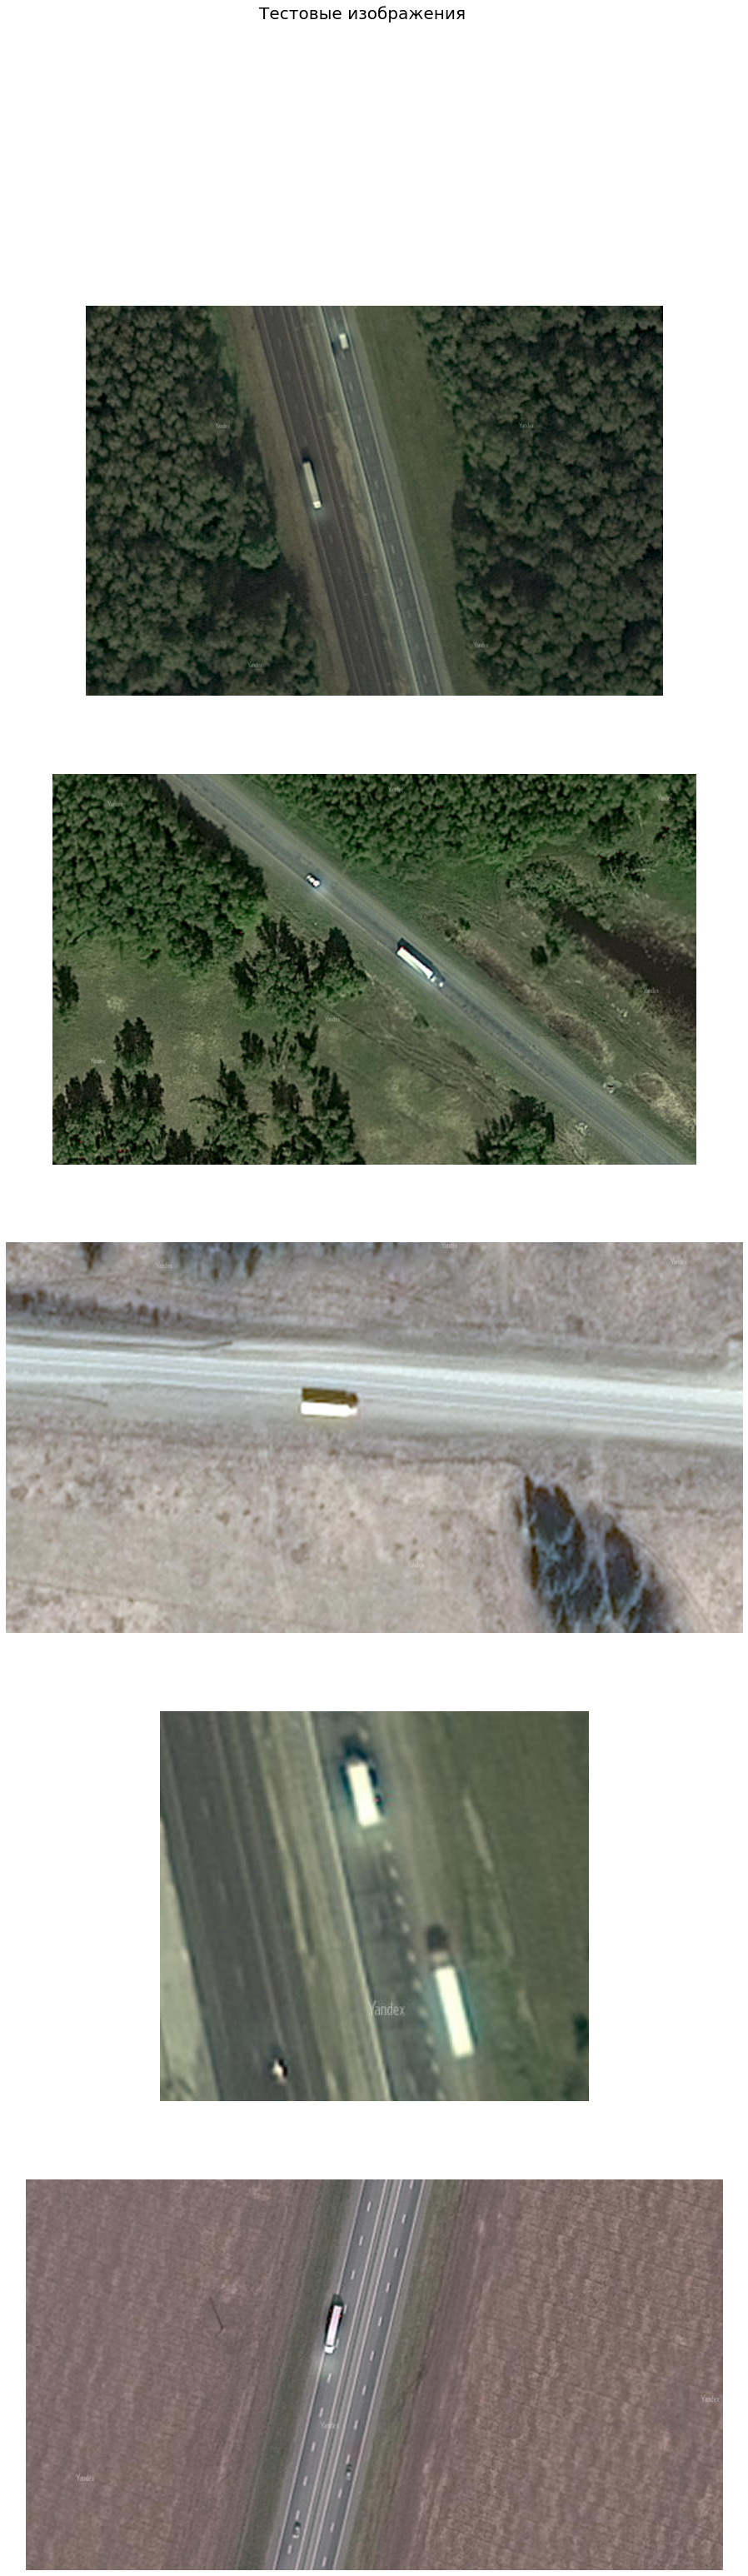

In [3]:
show_images(TEST_PATH, (5, 1), (16, 50),  suptitle='Тестовые изображения')

In [4]:
def read_images(path):
    images = []
    file_names = os.listdir(path)
    for file_name in file_names:
        image = io.imread(os.path.join(path, file_name), as_gray=True)
        images.append(image)
    return images


trucks = read_images(TRUCKS_PATH)
nontrucks = read_images(NONTRUCKS_PATH)
images = trucks + nontrucks

In [5]:
def extract_feature_values(img, feature_coords=None, feature_types=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    values = haar_like_feature(
        ii, 0, 0, DETECTION_WINDOW_WIDTH, DETECTION_WINDOW_HEIGHT,
        feature_type=feature_types,
        feature_coord=feature_coords
    )
    return values


x = []
for img in images:
    x.append(extract_feature_values(img))
x = np.array(x)  # массив точек данных со всеми признаками
y = np.array(['truck'] * len(trucks) + ['nontruck'] * len(nontrucks))

In [6]:
# получаем список со значениями всех признаков и список с типами признаков
feature_coords, feature_types = haar_like_feature_coord(DETECTION_WINDOW_WIDTH, DETECTION_WINDOW_HEIGHT)

In [7]:
# классификатор, обученный на всех 78 тысячах признаках
classifier = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features=100, n_jobs=-1, random_state=0)
classifier.fit(x, y)

RandomForestClassifier(max_features=100, n_estimators=1000, n_jobs=-1,
                       random_state=0)

In [8]:
sorted_indexies = np.argsort(classifier.feature_importances_)[::-1]
best_100_indexies = sorted_indexies[:100]

In [9]:
new_x = []
for point in x:
    new_point = []
    for index in best_100_indexies:
        new_point.append(point[index])
    new_x.append(new_point)

best_feature_coords = []
for index in best_100_indexies:
    best_feature_coords.append(feature_coords[index])
best_feature_coords = np.array(best_feature_coords, dtype=object)

best_feature_types = []
for index in best_100_indexies:
    best_feature_types.append(feature_types[index])
best_feature_types = np.array(best_feature_types, dtype=object)

In [10]:
new_classifier = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features=100, n_jobs=-1, random_state=0)
new_classifier.fit(new_x, y)

RandomForestClassifier(max_features=100, n_estimators=1000, n_jobs=-1,
                       random_state=0)

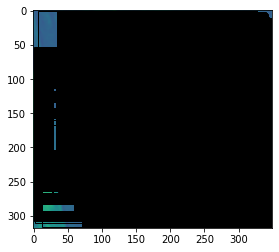

In [11]:
test_file_names = os.listdir(TEST_PATH)

test_images = read_images(TEST_PATH)
n_steps_w = test_images[0].shape[1]  # ширина
n_steps_h = test_images[0].shape[0]  # высота

ax = plt.subplot()
ax.imshow(test_images[0])
for w in range(n_steps_w - 150):
    for h in range(n_steps_h - 150):
        crop = test_images[0][h:h + 150, w:w + 150]  # вырезаем часть
        crop = resize(crop, (20, 20), anti_aliasing=True)  # ресайзим до 20х20
        # считаем для обрезка значение признаков
        feature_values = extract_feature_values(crop, best_feature_coords, best_feature_types)
        predict = new_classifier.predict([feature_values])  # получаем предсказание
        if predict == 'truck':
            draw_rectangle = patches.Rectangle((w, h), 150, 150, fill=False)
            ax.add_patch(draw_rectangle)
plt.show()

In [12]:
image_resized = resize(image, (20, 20), anti_aliasing=True)
plt.imshow(image_resized, cmap='gray')

NameError: name 'image' is not defined

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for ax in axes:
    image = np.zeros((20, 20))
    image = draw_haar_like_feature(image, 0, 0, 20, 20, [feature_coords[np.random.randint(0, len(feature_coords))]])
    ax.imshow(image)
    ax.set_axis_off()
fig.suptitle('Девять случайных Хаар-подобных признаков', fontsize=20)
plt.imshow(image)